# 1. Import

In [1]:
!pip install sklearn

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [3]:
import os
from os.path import basename, dirname, join


import glob
import argparse
import datetime
import random
import json
from netCDF4 import Dataset
import numpy as np

import seaborn as sebrn
import data_generator
from data_generator import (HugoDataGenerator,
                            DataGenerator_sod_f, 
                            HugoBinaryGenerator, 
                            HugoSarDataGenerator, 
                            HugoAMRS2DataGenerator)
import matplotlib.pyplot as plt
from matplotlib import colors

from sklearn.metrics import (confusion_matrix, 
                            mean_squared_error, 
                            accuracy_score,
                            precision_score,
                            recall_score)
from scipy import stats

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense,
                                     Flatten,
                                     Dropout,
                                     BatchNormalization, 
                                     Conv2D, 
                                     MaxPooling2D,
                                     Concatenate)
from tensorflow.keras.regularizers import l2


input_dir_json = '/tf/data/hugo_sod/'
idir = '/tf/data/hugo_sod/output_preprocessed/'

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
    except RuntimeError as e:
        print(e)


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-rmfqrp68 because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# 2. Definition model

In [4]:
def create_model():
    """
    create a keras model 
    """
        # number of ice classes
    nbr_classes = 32  
    # size of SAR subimages
    ws = 50
    # size of AMRS2 subimages
    ws2 = 10
    # size of convolutional filters
    cs = 3
    # number of filters per convolutional layer (x id)
    c1,c2,c3 = 32,32,32
    # number of neurons per hidden neural layer number (x id)
    n1,n2,n3 = 16,16,64
    # value of dropout
    dropout_rate = 0.1
    # value of L2 regularisation
    l2_rate = 0.001
    
    
    input_ = layers.Input(shape =(ws, ws, 4) )
    input_2 = layers.Input(shape = (ws2, ws2, 14))
    
    x = layers.BatchNormalization()(input_)
    x = layers.Conv2D(c1, (cs, cs),  activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2,2), strides=2)(x)
    x = layers.Conv2D(c2, (cs, cs), activation='relu')(x)
    x = layers.Conv2D(c3, (cs, cs), activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2,2), strides=2)(x)
    x = layers.BatchNormalization()(x)
    input_2 = BatchNormalization()(input_2)

    x = layers.Concatenate()([x, input_2])
    
    x = layers.Flatten()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(n1, kernel_regularizer=l2(l2_rate), activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(n2, kernel_regularizer=l2(l2_rate), activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(n3, kernel_regularizer=l2(l2_rate), activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    # Last neural layer (not hidden)
    x = layers.Dense(nbr_classes, kernel_regularizer=l2(l2_rate), activation='softmax')(x)

    model = Model(inputs=[input_, input_2], outputs=x)
    opt = tf.keras.optimizers.Adam()
    
    model.compile(optimizer=opt, loss='mean_squared_error')
    return model

# 3. Load Data

### 3.1 Parameters and load files

In [5]:
train_ratio = 0.7
with open(f'{idir}processed_files.json') as fichier_json:
    all_nc = json.load(fichier_json)
npz_files=[]
# all_nc=["20180410T084537_S1B_AMSR2_Icechart-Greenland-SouthEast.nc"]

for nc in all_nc :
    name = nc[:15]
    files = sorted(glob.glob(f'{idir}/{name}/*.npz'))
    npz_files += files
random.shuffle(npz_files)

# npz_files = npz_files[:10000]

print('Files number : '+ str (len(npz_files)))
train_files_number = int(len(npz_files) * train_ratio)
train_files = npz_files[:train_files_number]
valid_files = npz_files[train_files_number:]

input_var_names = ['nersc_sar_primary', 'nersc_sar_secondary']
amsr2_var_names = [
    'btemp_6_9h',
                   'btemp_6_9v',
                   'btemp_7_3h',
                   'btemp_7_3v',
                   'btemp_10_7h',
                   'btemp_10_7v',
                   'btemp_18_7h',
                   'btemp_18_7v',
                   'btemp_23_8h',
                   'btemp_23_8v',
                   'btemp_36_5h',
                   'btemp_36_5v',
                   'btemp_89_0h',
                   'btemp_89_0v'
                  ]

output_var_name = 'ice_type'
dims_amsr2 = np.load(npz_files[0])[amsr2_var_names[0]].shape


params = {'dims_amsr2':      (*dims_amsr2, len(amsr2_var_names)),
          'idir_json':       input_dir_json,
          'output_var_name': output_var_name,
          'input_var_names': input_var_names,
          'amsr2_var_names': amsr2_var_names,
          'batch_size':      50,
          'shuffle_on_epoch_end': False,
           }

Files number : 959614


### 3.2 processed data for model

In [6]:
training_generator = DataGenerator_sod_f(train_files, **params)
validation_generator = DataGenerator_sod_f(valid_files, **params)

print(
#      training_generator[0][0][0].shape, #sar
#      training_generator[0][0][1].shape, #amsr2
     training_generator[0][1].shape, #output
)


(50, 32)


# 4. Load model and trained weights

### 4.1 Load model and trained weights

In [11]:
# creation of the model 
model = create_model()


### 4.2 Apply CNN to SAR data

In [12]:
#callbacks
mc = tf.keras.callbacks.ModelCheckpoint(filepath='hugo_model_1000', 
                                        monitor='val_loss',
                                        verbose=1, 
                                        save_best_only=True,
                                        mode='min')

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)


model.summary()
history = model.fit(training_generator, 
                    use_multiprocessing=True,
                    workers=4,
                    validation_data=validation_generator,
                    epochs=1, 
                    callbacks=[mc, es])


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 50, 4)]  0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 50, 50, 4)   16          ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 conv2d (Conv2D)                (None, 48, 48, 32)   1184        ['batch_normalization[1][0]']    
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 24, 24, 32)   0           ['conv2d[1][0]']             

INFO:tensorflow:Assets written to: hugo_model_1000/assets


INFO:tensorflow:Assets written to: hugo_model_1000/assets


13434/13434 [==============================] - 1438s 107ms/step - loss: 0.0088 - val_loss: 0.0078


### 4.3 History of loss

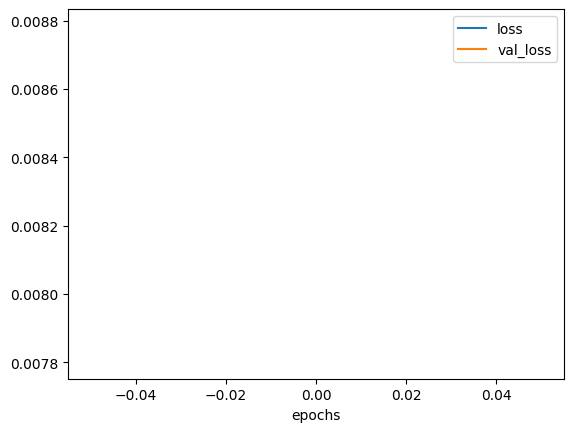

In [13]:
plt.clf()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('epochs')
plt.legend()
plt.show()

### 4.4 Metrics

In [14]:
y_pred = model.predict(validation_generator)
y_val = np.vstack([vg[1] for vg in validation_generator])


y_val_index =[]
y_pred_index =[]


  85/5757 [..............................] - ETA: 27:32

KeyboardInterrupt: 

#### Pearson ,rmse, rrmse matrices

In [ ]:
rmse_matrix=np.empty((32,32))
pearson_matrix = np.empty((32,32))
for id_class_pred in range(y_pred.shape[1]):
    classes_pred = y_pred[:,id_class_pred]
    for id_class_val in range (y_val.shape[1]):
        classes_val = y_val[:,id_class_val]
        rmse = mean_squared_error(classes_val, classes_pred)
        rmse_matrix[id_class_pred][id_class_val] = rmse
        pearson_value = stats.pearsonr(classes_val, classes_pred)
        pearson_matrix[id_class_pred][id_class_val] = pearson_value[0]

print('rmse_matrix')
rm=[]
for i in rmse_matrix :
    l=[]
    for j in i :
        l.append(np.round(j,8))
    rm.append(l)
print(rm)

    
print('pearson_matrix')
pm=[]
for i in pearson_matrix :
    l=[]
    for j in i :
        l.append(np.round(j,8))
    pm.append(l)
print(pm)


with open(f'{input_dir_json}/vector_combinations.json') as fichier_json:
    list_combi = json.load(fichier_json)['all_work_comb']
y_ticks= [(i+0.5) for i in range (32)]


plt.clf()
plt.figure(figsize=(18,18))
fx = sebrn.heatmap(pearson_matrix, annot=True, cmap='bwr', fmt=".3f", cbar=False)
fx.set_title('Pearson correlation Matrix \n')
fx.set_xlabel('Predicted Values')
fx.set_ylabel('True Values ')
fx.xaxis.set_ticklabels(list_combi)
fx.xaxis.tick_top()
fx.set_yticks(y_ticks)
fx.yaxis.set_ticklabels(ticklabels=list_combi)
plt.savefig('test_pm')
plt.show()




# Using Seaborn heatmap to create the plot
plt.clf()
plt.figure(figsize=(18,18))
fx = sebrn.heatmap(rmse_matrix, annot=True, cmap='Blues', fmt=".3f", cbar=False)
fx.set_title('RMSE Matrix \n')
fx.set_xlabel('Predicted Values')
fx.set_ylabel('True Values ')
fx.xaxis.set_ticklabels(list_combi)
fx.xaxis.tick_top()
fx.set_yticks(y_ticks)
fx.yaxis.set_ticklabels(ticklabels=list_combi)
plt.savefig('test_rmse')
plt.show()

